In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**modules.py**

In [ ]:
import torch
from torch.nn.functional import fold, unfold

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# implemented modules and losses will inherit from Module
class Module(object):
    # forward should get for input and returns, a tensor or a tuple of tensors
    def forward(self, *input):
        raise NotImplementedError

    # backward should get as input a tensor or a tuple of tensors containing the gradient of the loss with respect to
    # the module’s output, accumulate the gradient wrt the parameters, and return a tensor or a tuple of tensors
    # containing the gradient of the loss wrt the module’s input.
    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    # param should return a list of pairs composed of a parameter tensor and a gradient tensor of the same size.
    # This list should be empty for parameterless modules (such as ReLU).
    def param(self):
        return []

    def step(self):
        raise NotImplementedError

    def zero_grad(self):
        raise NotImplementedError

# Convolution layer
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.dilation = dilation if isinstance(dilation, tuple) else (dilation, dilation)

        # Xavier initialization
        a = 3**0.5 * (2/((self.in_channels + self.out_channels) * self.kernel_size[0] * self.kernel_size[1]))**0.5
        self.weight = torch.empty(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]).uniform_(-a, a).to(device)
        self.d_weight = torch.empty(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]).zero_().to(device)
        self.bias = torch.empty(out_channels).uniform_(-a, a).to(device)
        self.d_bias = torch.empty(out_channels).zero_().to(device)

    def forward(self, input):
        self.input = input.to(device)
        self.input_unfolded = unfold(self.input, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, dilation=self.dilation)
        wxb = self.weight.view(self.out_channels, -1) @ self.input_unfolded + self.bias.view(1, -1, 1)
        wxb = wxb.view(self.input.shape[0], self.out_channels,
                       int((self.input.shape[2] + 2*self.padding[0] - self.dilation[0]*(self.kernel_size[0]-1) - 1)/self.stride[0] + 1),
                       int((self.input.shape[3] + 2*self.padding[1] - self.dilation[1]*(self.kernel_size[1]-1) - 1)/self.stride[1] + 1))
        # print('wxb reshaped : ', wxb.shape)
        return wxb

    def backward(self, gradwrtoutput):
        # print(gradwrtoutput.shape)
        gradwrtoutput_reshaped = gradwrtoutput.permute(1, 2, 3, 0).reshape(self.out_channels, -1)
        # print(gradwrtoutput_reshaped.shape)
        input_unfolded_reshaped = self.input_unfolded.permute(2, 0, 1).reshape(gradwrtoutput_reshaped.shape[1], -1)
        # print(input_unfolded_reshaped.shape)
        self.d_weight.data = torch.matmul(gradwrtoutput_reshaped, input_unfolded_reshaped).reshape(self.weight.shape)
        # print(self.d_weight.data.shape)
        self.d_bias.data = gradwrtoutput.sum(axis=(0,2,3))
        # print(self.d_bias.data.shape)
        weight_reshaped = self.weight.reshape(self.out_channels, -1)
        # print(weight_reshaped.shape)
        d_input_unfolded = torch.matmul(weight_reshaped.t(), gradwrtoutput_reshaped)
        # print(d_input_unfolded.shape)
        d_input_unfolded = d_input_unfolded.reshape(self.input_unfolded.permute(1, 2, 0).shape)
        # print(d_input_unfolded.shape)
        d_input_unfolded = d_input_unfolded.permute(2, 0, 1)
        # print(d_input_unfolded.shape)
        d_input = fold(d_input_unfolded, (self.input.shape[2], self.input.shape[3]), kernel_size=self.kernel_size,
                                          stride=self.stride, padding=self.padding, dilation=self.dilation)
        # print(d_input.shape)
        return d_input

    def param(self):
        return [[self.weight, self.d_weight],
                [self.bias, self.d_bias]]

# Upsampling layer, which is usually implemented with transposed convolution, but you can alternatively use a combination of Nearest neighbor upsampling + Convolution for this mini-project
class NearestUpsampling(Module):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor if isinstance(scale_factor, tuple) else (scale_factor, scale_factor)

    def forward(self, input):
        self.input = input
        # print(input.shape)
        upsampled_input = self.input.repeat_interleave(self.scale_factor[1], dim=3)
        upsampled_input = upsampled_input.repeat_interleave(self.scale_factor[0], dim=2)
        # print(upsampled_input.shape)
        return upsampled_input

    def backward(self, gradwrtoutput):
        d_input = gradwrtoutput.unfold(dimension=3, size=self.scale_factor[1], step=self.scale_factor[1])
        d_input = d_input.sum(dim=4)
        d_input = d_input.unfold(dimension=2, size=self.scale_factor[0], step=self.scale_factor[0])
        d_input = d_input.sum(dim=4)
        d_input = d_input.div(self.scale_factor[0] * self.scale_factor[1])
        return d_input

    def param(self):
        return []

# ReLU
class ReLU(Module):
    def __init__(self):
        pass

    def forward(self, input):
        self.input = input  # save previous input for backward step
        output = self.input  # prepare output
        output[output < 0] = 0  # relu function
        return output

    def backward(self, gradwrtoutput):
        # print(gradwrtoutput[0, 0, :, :])
        return gradwrtoutput * (self.input > 0)

    def param(self):
        return []

# Sigmoid
class Sigmoid(Module):
    def __init__(self):
        pass

    def forward(self, input):
        self.sigma = input.sigmoid()  # save previous sigma for backward step
        return self.sigma

    def backward(self, gradwrtoutput):
        return gradwrtoutput * self.sigma * (1 - self.sigma)

    def param(self):
        return []

# container to put together an arbitrary configuration of modules together
class Sequential(Module):
    def __init__(self, *args):
        self.blocks = list(args)

    def forward(self, input):
        for b in self.blocks:
            # the input of the next layer is the output of the previous layer
            input = b.forward(input)
        # print('input', input.size())
        return input

    def backward(self, gradwrtoutput):
        for b in reversed(self.blocks):
            # output of the previous layer is the input of the next layer
            gradwrtoutput = b.backward(gradwrtoutput)
        # print('gradwrtoutput', gradwrtoutput.size())
        return gradwrtoutput

    def param(self):
        # Regroup the parameters of each block of Sequential inside block_parameters_list
        block_parameters_list = []
        for b in self.blocks:
            for p in b.param():
                block_parameters_list.append(p)
        # print(len(block_parameters_list))
        return block_parameters_list

# Mean Squared Error Loss Function
class MSE(Module):
    def __init__(self):
        pass

    def forward(self, input, target):
        self.input = input
        self.target = target
        self.loss = ((input-target)**2).mean()
        return self.loss

    def backward(self):
        self.output = 2 * (self.input-self.target) / (self.input.shape[0] * self.input.shape[1] * self.input.shape[2] * self.input.shape[3])
        return self.output

    def param(self):
        return []

# Stochastic Gradient Descent (SGD) optimizer
class SGD(Module):
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def step(self):
        for [param, d_param] in self.params:
            param.data.add_(-self.lr * d_param)  # put d_param to 0

    def zero_grad(self):
        for p in self.param():
            p[1].zero_()  # put d_param to 0

    def param(self):
        return self.params



**model.py**

In [ ]:
import torch
import torch.nn as nn
from torch import optim
# from Miniproject_2.other.net import *
# from Miniproject_2.other.modules import Conv2d, TransposeConv2d, NearestUpsampling, ReLU, Sigmoid, Sequential, MSE, SGD
# model.py will be imported by the testing pipeline


class Model():
    def __init__(self, lr=10) -> None:
        ## instantiate model + optimizer + loss function + any other stuff you need

        self.model = Sequential(
            Conv2d(in_channels=3, out_channels=128, kernel_size=2, stride=2, padding=0),
            ReLU(),
            Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2, padding=0),
            ReLU(),
            NearestUpsampling(scale_factor=2),
            Conv2d(in_channels=256, out_channels=128, kernel_size=2, stride=1, padding=1),
            ReLU(),
            NearestUpsampling(scale_factor=2),
            Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=0),
            Sigmoid()
        )

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        # self.model.to(self.device)

        self.learning_rate = lr

        # self.criterion = nn.CrossEntropyLoss()
        self.criterion = MSE()
        self.optimizer = SGD(self.model.param(), lr=self.learning_rate)

    def save_model(self, path='Miniproject_2/bestmodel.pth') -> None:
        ## This saves the parameters of the model into bestmodel.pth
        torch.save(self.model.param().cpu(), path)
        # print('model saved to bestmodel.pth')

    def load_pretrained_model(self, path='Miniproject_2/bestmodel.pth') -> None:
        ## This loads the parameters saved in bestmodel.pth into the model
        m_state_dict = torch.load(path)

        # print('m_state_dict : ', m_state_dict[1][0])

        self.model.blocks[0].weight.data = m_state_dict[0][0].to(self.device)
        self.model.blocks[0].d_weight.data = m_state_dict[0][1].to(self.device)
        self.model.blocks[0].bias.data = m_state_dict[1][0].to(self.device)
        self.model.blocks[0].d_bias.data = m_state_dict[1][1].to(self.device)
        self.model.blocks[2].weight.data = m_state_dict[2][0].to(self.device)
        self.model.blocks[2].d_weight.data = m_state_dict[2][1].to(self.device)
        self.model.blocks[2].bias.data = m_state_dict[3][0].to(self.device)
        self.model.blocks[2].d_bias.data = m_state_dict[3][1].to(self.device)
        self.model.blocks[5].weight.data = m_state_dict[4][0].to(self.device)
        self.model.blocks[5].d_weight.data = m_state_dict[4][1].to(self.device)
        self.model.blocks[5].bias.data = m_state_dict[5][0].to(self.device)
        self.model.blocks[5].d_bias.data = m_state_dict[5][1].to(self.device)
        self.model.blocks[8].weight.data = m_state_dict[6][0].to(self.device)
        self.model.blocks[8].d_weight.data = m_state_dict[6][1].to(self.device)
        self.model.blocks[8].bias.data = m_state_dict[7][0].to(self.device)
        self.model.blocks[8].d_bias.data = m_state_dict[7][1].to(self.device)

    # print('model loaded')

    def train(self, train_input, train_target, num_epochs=7, mini_batch_size=4, scheduler_gamma=1, lambda_l2=0) -> None:
        #: train_input : tensor of size (N, C, H, W) containing a noisy version of the images.
        #: train_target : tensor of size (N, C, H, W) containing another noisy version of the same images, which only differs from the input by their noise.

        torch.set_grad_enabled(False)

        train_input, train_target = train_input.to(self.device), train_target.to(self.device)

        train_input = train_input.float().div(255)
        train_target = train_target.float().div(255)

        for e in range(num_epochs):

            self.learning_rate = self.learning_rate * scheduler_gamma
            self.optimizer = SGD(self.model.param(), lr=self.learning_rate)

            for b in range(0, train_input.size(dim=0), mini_batch_size):
                self.optimizer.zero_grad()

                # forward pass
                output = self.model.forward(train_input.narrow(dim=0, start=b, length=mini_batch_size)) # takes time
                loss = self.criterion.forward(output, train_target.narrow(dim=0, start=b, length=mini_batch_size))

                # L2 penalty term (to avoid overfitting the training data for an increasing number of epochs)
                for p in self.model.param():
                    loss += lambda_l2 * ((p[0]**2).sum() + (p[1]**2).sum())

                # backward pass
                d_loss_d_y = self.criterion.backward().to(self.device)
                self.model.backward(d_loss_d_y)

                self.optimizer.step()
            print('epoch {:d}/{:d}'.format(e + 1, num_epochs), 'training loss = {:.5f}'.format(loss))

    def predict(self, test_input) -> torch.Tensor:
        #: test_input : tensor of size (N1 , C, H, W) that has to be denoised by the trained or the loaded network.
        #: returns a tensor of the size (N1 , C, H, W)

        test_input = test_input.to(self.device)

        test_input = test_input.float().div(255)
        predicted_output = self.model.forward(test_input)
        predicted_output = predicted_output.mul(255).to(torch.uint8)

        return predicted_output


**run_miniproject_1.py**

noisy_imgs_train_1 torch.Size([50000, 3, 32, 32]) noisy_imgs_train_2 torch.Size([50000, 3, 32, 32])
noisy_imgs_valid torch.Size([1000, 3, 32, 32]) clean_imgs_valid torch.Size([1000, 3, 32, 32])
cuda:0
epoch 1/7 training loss = 0.01236
epoch 2/7 training loss = 0.01223
epoch 3/7 training loss = 0.01214
epoch 4/7 training loss = 0.01208
epoch 5/7 training loss = 0.01203
epoch 6/7 training loss = 0.01196
epoch 7/7 training loss = 0.01190
mean psnr = 24.41745 dB std psnr = 2.81867 dB


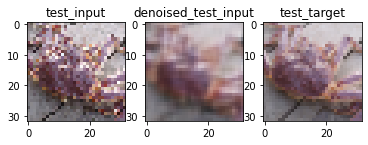

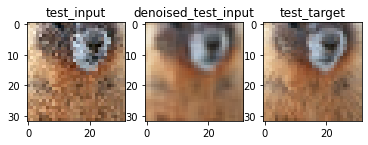

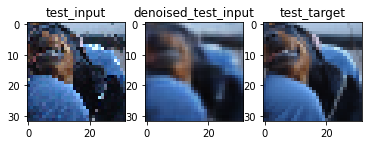

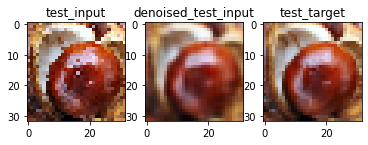

In [ ]:
import torch
from torch.utils.data import (DataLoader,)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt

# from Miniproject_2.model import Model

path_to_project = '/content/drive/MyDrive/Colab Notebooks/'

# noisy_imgs_train_1, noisy_imgs_train_2 = torch.load('miniproject_dataset/train_data.pkl')
# noisy_imgs_valid, clean_imgs_valid = torch.load('miniproject_dataset/val_data.pkl')
noisy_imgs_train_1, noisy_imgs_train_2 = torch.load(open(path_to_project + 'miniproject_dataset/train_data.pkl', 'rb'))
noisy_imgs_valid, clean_imgs_valid = torch.load(open(path_to_project + 'miniproject_dataset/val_data.pkl', 'rb'))

print('noisy_imgs_train_1', noisy_imgs_train_1.size(), 'noisy_imgs_train_2', noisy_imgs_train_2.size())
print('noisy_imgs_valid', noisy_imgs_valid.size(), 'clean_imgs_valid', clean_imgs_valid.size())


def compute_psnr_mean(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()

def compute_psnr_std(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).std()

def plot_images(*args, titles):
    for i in range(args[0].size(dim=0)): # number images to plot for each dataset
        if len(args) > 1: _, axes = plt.subplots(1, len(args))
        for img, idx in zip(args, range(len(args))): # number datasets to plot
            if len(args) > 1:
                axes[idx].imshow(img[i,:,:,:].permute((1, 2, 0)))
                axes[idx].set_title(titles[idx])
            else:
                plt.imshow(img[i, :, :, :].permute((1, 2, 0)))
                plt.title(titles[idx])
        plt.show()

# transform data
my_transforms = transforms.Compose(
    [   # Compose makes it possible to have many transforms
        # transforms.ToPILImage(),
        # transforms.Resize((36, 36)),  # Resizes (32,32) to (36,36)
        # transforms.RandomCrop((32, 32)),  # Takes a random (32,32) crop
        # transforms.ColorJitter(brightness=0.5),  # Change brightness of image
        # transforms.RandomRotation(degrees=45),  # Perhaps a random rotation from -45 to 45 degrees
        transforms.RandomHorizontalFlip(p=1),  # Flips the image horizontally with probability 0.5
        transforms.RandomVerticalFlip(p=1),  # Flips image vertically with probability 0.05
        # transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
        # transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Note: these values aren't optimal
    ]
)

data_augmentation = False
augmented_train_data_upper_index = 50000

if data_augmentation:
    transformed_imgs = my_transforms(torch.cat((noisy_imgs_train_1[0:augmented_train_data_upper_index, :, :, :], noisy_imgs_train_2[0:augmented_train_data_upper_index, :, :, :]), dim=0))

    noisy_imgs_train_1 = torch.cat((noisy_imgs_train_1, transformed_imgs[0:int(len(transformed_imgs)/2)]), dim=0)
    noisy_imgs_train_2 = torch.cat((noisy_imgs_train_2, transformed_imgs[int(len(transformed_imgs)/2):int(len(transformed_imgs))]), dim=0)

    # print(len(noisy_imgs_train_1), len(noisy_imgs_train_2))
    # plot_images(transformed_imgs, titles=['transformed_imgs'])

################################################################################

#subset of data
train_data_upper_index = 50000
train_input = noisy_imgs_train_1[0:train_data_upper_index, :, :, :]
train_target = noisy_imgs_train_2[0:train_data_upper_index, :, :, :]
test_input = noisy_imgs_valid[0:1000, :, :, :]
test_target = clean_imgs_valid[0:1000, :, :, :]

model = Model(lr=10)

# train
# model.train(train_input, train_target, num_epochs=7, mini_batch_size=4, scheduler_gamma=1, lambda_l2=0)
# model.save_model(path_to_project + 'Miniproject_2/bestmodel.pth')

# load model
model.load_pretrained_model(path_to_project + 'Miniproject_2/bestmodel.pth')

# denoise input
denoised_test_input = model.predict(test_input).cpu()

# PSNR
psnr_mean = float(compute_psnr_mean(denoised_test_input.float().div(255), test_target.float().div(255)))
psnr_std = abs(float(compute_psnr_std(denoised_test_input.float().div(255), test_target.float().div(255))))
print('mean psnr = {:.5f}'.format(psnr_mean),'dB', 'std psnr = {:.5f}'.format(psnr_std),'dB')

# plot denoised image
plot_images(test_input[0:4,:,:,:], denoised_test_input[0:4,:,:,:].detach(), test_target[0:4,:,:,:],
            titles=['test_input','denoised_test_input','test_target'])

